In [7]:
import numpy as np
import matplotlib.pyplot as plt
import flpoAgent
import importlib
import random
from scipy.spatial.distance import cdist
import createEnv
from scipy.optimize import Bounds, LinearConstraint, minimize
import supporting_functions
from matplotlib.cm import get_cmap

n_waypoints: 6 
n_agents: 3 
CAT:
[3. 3. 3. 3. 3. 3.] 
b1:
[0.7 0.7 0.7 0.7 0.7 0.7] 
b2:
[0. 0. 0. 0. 0. 0.]
---------
wp_locations:
[[-6.39460622e+00 -9.61049517e+00]
 [ 4.99264371e+02  4.49867858e+00]
 [ 9.98404072e+02 -2.91458037e-01]
 [-9.74438371e+00  4.99747432e+02]
 [ 5.08836133e+02  5.07015902e+02]
 [ 1.00459929e+03  4.92174721e+02]] 
mask:
[[0 1 0 1 0 0]
 [1 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 0]] 
dist_mat:
[[1.00000000e+08 5.05855779e+02 1.00000000e+08 5.09368942e+02
  1.00000000e+08 1.00000000e+08]
 [5.05855779e+02 1.00000000e+08 4.99162686e+02 1.00000000e+08
  5.02608375e+02 1.00000000e+08]
 [1.00000000e+08 4.99162686e+02 1.00000000e+08 1.00000000e+08
  1.00000000e+08 4.92505146e+02]
 [5.09368942e+02 1.00000000e+08 1.00000000e+08 1.00000000e+08
  5.18631452e+02 1.00000000e+08]
 [1.00000000e+08 5.02608375e+02 1.00000000e+08 5.18631452e+02
  1.00000000e+08 4.95985250e+02]
 [1.00000000e+08 1.00000000e+08 4.92505146e+02 1.00000000e+08
  4.95985

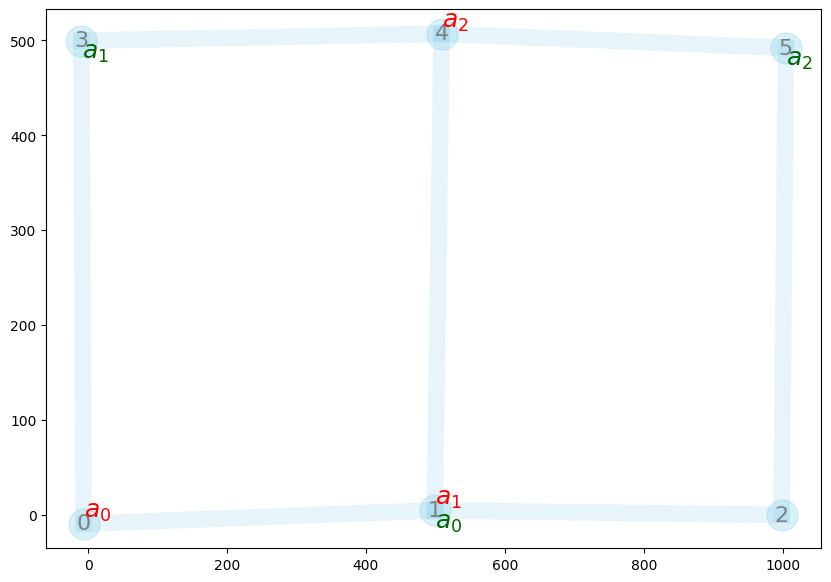

In [8]:
importlib.reload(flpoAgent)
importlib.reload(createEnv)
importlib.reload(supporting_functions)

# generate waypoints and the adjacency matrix
n_waypoints = 6
n_agents = 3
tolArray = np.random.uniform(3.0, 3.0, n_waypoints)
b1 = np.ones(n_waypoints)*0.7
b2 = np.ones(n_waypoints)*0.0

# Grid network parameters
grid_params = {
    'type':'grid',
    'n_points':n_waypoints,
    'grid_size':1000,
    'noise_factor':10
}

# Ring network parameters
ring_params = {
    'type':'ring',
    'num_rings':3,
    'points_per_ring':int(n_waypoints/3),
    'center_distance':200,
    'deformation_level':50.0,
    'extra_connections':0.00,
    'missing_connections':0.05
}

# create a mars environment
mars = createEnv.MARS(
    n_waypoints, 
    n_agents, 
    tolArray, 
    b1, 
    b2, 
    grid_params, 
    seed=11, 
    printFlag=True)

# compute conflict cost
beta0=1e-8
gamma_t = 5e0
gamma_c = 1e-2
coeff_t = 50
coeff_c = 0.01
# calculate conflict cost
# print(f'mars_schedule:\n{np.round(mars.sched_mat,2)}')
# Xi = mars.agents[1].returnStageWiseCost(mars.sched_mat[1,:], mars.dist_mat, gamma_t, coeff_t)
# Pb = mars.agents[1].getPathAssociations(mars.sched_mat[1,:], mars.dist_mat, beta0, gamma_t, coeff_t)
# print(f'agent start:{mars.agents[1].s}\nprobability:\n{Pb[1]}\nstageWiseCost:{Xi[1]}')

reach_mat = mars.calc_agent_reach_mat(
        mars.sched_mat, 
        beta=beta0, gamma=gamma_t, coeff=coeff_t)
filter_wp = np.ones(shape=reach_mat.shape)
filter_wp[reach_mat <= 1.0e-10] = 0.0 
print(f'reach_mat')
print(f'filter_wp:\n{filter_wp}')
mars.transportCost(mars.sched_mat, beta=beta0, gamma=gamma_t, coeff=coeff_t)
print(f'transport_cost:\n{mars.C_agents}')
mars.conflictCost(mars.sched_mat, gamma=gamma_c, coeff=coeff_c, filter_wp=filter_wp)
print(f'conflict_cost:\n{mars.C_wp_conflict}')

# mars visualization
# agent_routes, agent_schedules, agent_colors = createEnv.calc_agent_routes_and_schedules(mars, Pb_a=[], printRoutes=False)
cmap = get_cmap('tab20')
agent_colors = {a: cmap(i / mars.n_agents) for i, a in enumerate(range(mars.n_agents))}
createEnv.plotNetwork(mars=mars, figuresize=(10,7), routes=[], agent_colors=agent_colors, showEdgeLength=False, plotPaths=False)

# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True)



### Write a code to flatten the scheduling matrix row-wise ($y$) and column-wise ($z$) and construct a linear transformation between them $A$.

In [9]:
def compute_transformation_matrix(rows, cols):
    # Total number of elements
    n = rows * cols

    # Create a basis for all standard basis vectors in column-wise (z) order
    A = np.zeros((n, n))

    for i in range(n):
        # Create one-hot vector in column-wise order
        z = np.zeros((rows, cols))
        # Get the (row, col) index for column-wise flattening
        row = i % rows
        col = i // rows
        z[row, col] = 1

        # Flatten row-wise to get the i-th column of A
        y = z.flatten(order='C')  # 'C' means row-major
        A[:, i] = y

    return A

# compute transformation
Azy = compute_transformation_matrix(mars.n_agents, mars.n_waypoints)
# verify
Tmat = mars.sched_mat
y = Tmat.flatten()
z = (Tmat.T).flatten()
err1 = y - Azy @ z
err2 = Azy.T @ y - z
err3 = np.max(np.abs(Azy.T @ Azy - np.eye(mars.n_agents * mars.n_waypoints)))

# print("Transformation matrix A:z-->y\n", Azy)
# print(f'norms:\tres1 {np.linalg.norm(res1)}\tres2 {np.linalg.norm(res2)}\tres3 {np.linalg.norm(res3)}')


### Formulate and solve the ADMM optimization problem

In [10]:
def lagrangian_y(y, mars, zk, lk, Azy, beta, gamma, coeff, rho=0.1):
    Tmat = y.reshape(-1, mars.n_waypoints)
    mars.transportCost(Tmat, beta, gamma, coeff) # function y
    phi1_y = np.sum(mars.C_agents)
    linear_term = lk @ y
    quadratic_term = rho/2 * np.linalg.norm(y - Azy @ zk)**2
    # print(f'{type(phi1_y), type(linear_term), type(quadratic_term)}')
    cost = phi1_y + linear_term + quadratic_term
    return cost

def lagrangian_z(z, mars, yk1, lk, Azy, gamma, coeff, rho=0.1):
    Tmat = z.reshape(-1, mars.n_agents).T
    mars.conflictCost1(Tmat, gamma, coeff)
    phi2_z = np.sum(mars.C_wp_conflict)
    linear_term = -lk @ (Azy @ z)
    quadratic_term = rho/2 * np.linalg.norm(yk1 - Azy @ z)**2
    cost = phi2_z + linear_term + quadratic_term
    return cost

def update_dual(lk, yk1, zk1, Azy, rho=0.1):
    lk1 = lk + rho * (yk1 - Azy @ zk1)
    return lk1


def admm_iters_at_beta(
    mars, 
    y0, 
    z0, 
    l0, 
    bounds, 
    Azy, 
    beta, 
    n_iters_admm=50, 
    gamma_t=7,
    coeff_t=1,
    gamma_c=7,
    coeff_c=1,
    rho=0.1,
    allowPrint=False):

    yk, zk, lk = y0, z0, l0
    norm_yz_arr, norm_dphi1_yl_arr, norm_dphi2_zl_arr = [], [], []
    
    for i in range(n_iters_admm):

        # update yk given (yk, zk, lk)
        res_y = minimize(
            lagrangian_y,
            yk,
            args = (mars, zk, lk, Azy, beta, gamma_t, coeff_t, rho),
            method='slsqp',
            bounds = bounds,
            options={'disp':0}
        )
        yk1 = res_y.x
        jac_y = res_y.jac

        # update zk given (yk1, zk, lk)
        res_z = minimize(
            lagrangian_z,
            zk,
            args = (mars, yk1, lk, Azy, gamma_c, coeff_c, rho),
            method='slsqp',
            bounds = bounds,
            options={'disp':0}
        )
        zk1 = res_z.x
        jac_z = res_z.jac
        
        # update l given (yk1, zk1, lk)
        lk1 = update_dual(lk, yk1, zk1, Azy, rho)

        # convergence criteria and display results
        norm_yz = np.max(np.abs(yk1 - Azy @ zk1))
        dphi1_yl = np.max(np.abs(jac_y + lk1))
        dphi2_zl = np.max(np.abs(jac_z - Azy.T @ lk1))

        norm_yz_arr.append(norm_yz)
        norm_dphi1_yl_arr.append(dphi1_yl)
        norm_dphi2_zl_arr.append(dphi2_zl)

        if allowPrint:
            print(f'i:{i}\tnorm_yz: {norm_yz:.4f}\tdphi1_yl: {dphi1_yl:.4f}\tdphi2_zl: {dphi2_zl:.4f}')

        # update current variables
        yk = yk1
        zk = zk1
        lk = lk1

    convergence_data = np.zeros(shape=(3, len(norm_yz_arr)))
    convergence_data[0,:] = np.array(norm_yz_arr)
    convergence_data[1,:] = np.array(norm_dphi1_yl_arr)
    convergence_data[2,:] = np.array(norm_dphi2_zl_arr)

    return yk, zk, lk, convergence_data



### Code to perform the ADMM iterations in loop

In [11]:
# lb0 = np.zeros(mars.n_agents * mars.n_waypoints)
# ub0 = 1000 * np.ones(mars.n_agents * mars.n_waypoints)
# bounds = Bounds(lb0, ub0)

# y0 = Tmat.flatten()
# z0 = (Tmat.T).flatten() + np.random.multivariate_normal(np.zeros(y.shape), 2e-2 * np.eye(y.shape[0]))
# l0 = np.random.uniform(0.0, 10.0, (y.shape))
# beta = 100
# gamma_t = 5
# gamma_c = 7.5
# coeff_t = 50
# coeff_c = 5.0
# rho = 0.1
# norm_yz_arr = []
# primal_dual_res = []

# n_iters_admm = 20

# y1, z1, l1, convergence_data = admm_iters_at_beta(mars, y0, z0, l0, bounds, Azy, beta, n_iters_admm, gamma_t, coeff_t, gamma_c, coeff_c, rho, allowPrint=True)

In [12]:
# norm_yz_arr = convergence_data[0,:]
# norm_dphi1_yl_arr = convergence_data[1,:]
# norm_dphi2_yz_arr = convergence_data[2,:]

# plt.figure(figsize=(8,6))

# plt.subplot(3,1,1)
# plt.plot(norm_yz_arr, marker='x')
# # plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\hat y_k - A \hat z_k|_\infty$')
# plt.grid()

# plt.subplot(3,1,2)
# plt.plot(norm_dphi1_yl_arr, marker='.')
# # plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\nabla \Phi_1(y_{{k}}) + \lambda_k|_\infty$')
# plt.grid()

# plt.subplot(3,1,3)
# plt.plot(norm_dphi2_yz_arr, marker='.')
# plt.xlabel('Iterations (k)')
# plt.ylabel(rf'$|\nabla \Phi_2(z_{{k}}) - A^T\lambda_k|_\infty$')
# plt.grid()

# plt.show()

In [13]:
# error_final = y1 - Azy @ z1
# plt.figure(figsize=(8,2))
# plt.plot(error_final, marker='d')
# plt.title(rf'Component-wise error plot of $\hat y_k-A \hat z_k$ for k={n_iters_admm}')
# plt.grid()
# plt.show()

### Code to perform Annealing with ADMM iterations

In [14]:
beta_min = 1e-3
beta_max = 1e2
beta_grow = 3
beta = beta_min

lb0 = np.zeros(mars.n_agents * mars.n_waypoints)
ub0 = 1000 * np.ones(mars.n_agents * mars.n_waypoints)
bounds = Bounds(lb0, ub0)

yb = Tmat.flatten()
zb = (Tmat.T).flatten() + np.random.multivariate_normal(np.zeros(y.shape), 1e-3 * np.eye(y.shape[0]))
lib = np.random.uniform(0.0, 10.0, (y.shape))

gamma_t = 5
gamma_c = 7.5
coeff_t = 50
coeff_c = 5.0
# gamma_t = 7
# gamma_c = 7
# coeff_t = 1
# coeff_c = 1
rho = 0.1
n_iters_admm = 20

while beta <= beta_max:
    
    yb1, zb1, lib1, convergence_data_beta = admm_iters_at_beta(
        mars, yb, zb, lib, bounds, Azy, beta, n_iters_admm, 
        gamma_t, coeff_t, gamma_c, coeff_c, rho, 
        allowPrint=False)
    
    norm_yz = convergence_data_beta[0,-1]
    norm_dphi1_yl = convergence_data_beta[1,-1]
    norm_dphi2_yz = convergence_data_beta[2,-1]
    print(f'beta: {beta:.3e}\tp_feas: {norm_yz:.4f}\td_feas1: {(norm_dphi1_yl):.4f}\td_feas2: {(norm_dphi2_yz):.4f}')

    if beta == beta_min:
        convergence_data = np.array([convergence_data_beta])
    else:
        convergence_data = np.concatenate((
            convergence_data,
            np.array([convergence_data_beta])
        ), axis=0)
    
    beta = beta * beta_grow
    yb = yb1
    zb = zb1
    lib = lib1


beta: 1.000e-03	p_feas: 0.0000	d_feas1: 0.0009	d_feas2: 0.0000
beta: 3.000e-03	p_feas: 0.0000	d_feas1: 1.0059	d_feas2: 0.0000
beta: 9.000e-03	p_feas: 1.6262	d_feas1: 1.7494	d_feas2: 3.3648
beta: 2.700e-02	p_feas: 0.9692	d_feas1: 1.3444	d_feas2: 3.2328
beta: 8.100e-02	p_feas: 0.9058	d_feas1: 3.3836	d_feas2: 4.7098
beta: 2.430e-01	p_feas: 1.3380	d_feas1: 1.6564	d_feas2: 2.1719
beta: 7.290e-01	p_feas: 0.8533	d_feas1: 1.8853	d_feas2: 3.9280
beta: 2.187e+00	p_feas: 1.3650	d_feas1: 2.6821	d_feas2: 1.2756
beta: 6.561e+00	p_feas: 1.7422	d_feas1: 1.6963	d_feas2: 0.7644
beta: 1.968e+01	p_feas: 0.7909	d_feas1: 1.7100	d_feas2: 0.7214
beta: 5.905e+01	p_feas: 2.6475	d_feas1: 1.7565	d_feas2: 3.6139


In [15]:
# update mars schedule with final yb1
mars.sched_mat = yb1.reshape(-1, mars.n_waypoints)

# compute final probability associations
Pb_a = []
for i,a in enumerate(mars.agents):
    Pb = a.getPathAssociations(mars.sched_mat[i,:], mars.dist_mat, beta_max, gamma_t, coeff_t)
    Pb_a.append(Pb)

In [16]:
agent_routes, agent_schedules = createEnv.calc_agent_routes_and_schedules(mars, Pb_a, printRoutes=True)

route v0: [1, 4, 3, 0], schedule: [ 0.   19.14 39.18 59.24]
route v1: [3, 0, 1], schedule: [ 0.   17.68 38.08]
route v2: [5, 2, 1, 4], schedule: [ 0.   16.69 33.11 50.27]


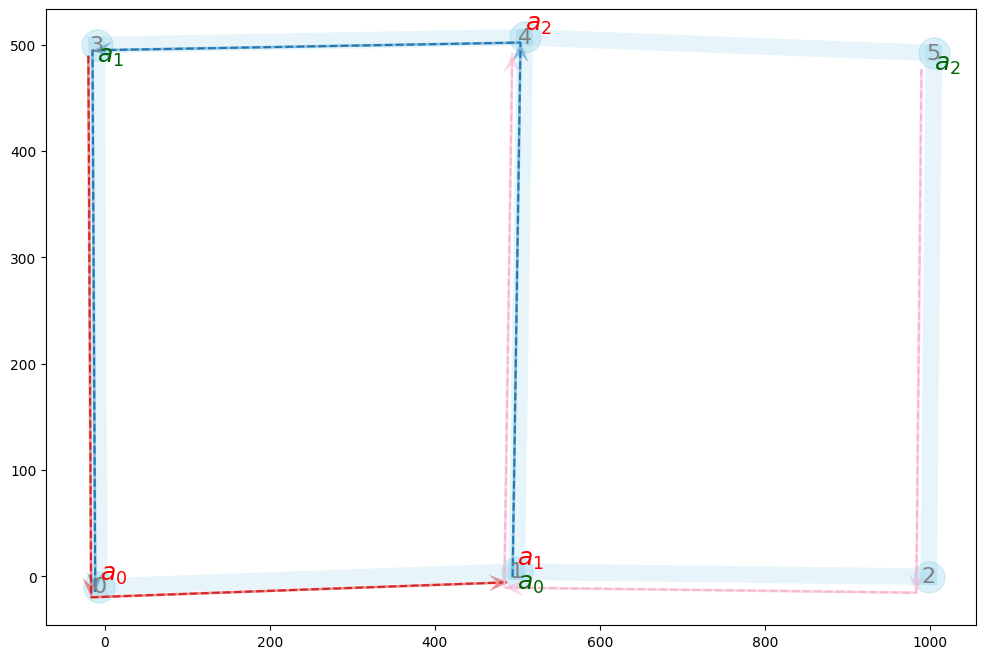

In [17]:
createEnv.plotNetwork(mars=mars, figuresize=(12,8), routes=agent_routes, agent_colors=agent_colors, showEdgeLength=False, plotPaths=True)

In [18]:
reach_mat = mars.calc_agent_reach_mat(mars.sched_mat, beta=beta_max, gamma=gamma_t, coeff=coeff_t)
filter_wp_final = np.ones(shape=reach_mat.shape)
filter_wp_final[reach_mat <= 1.0e-10] = 0.0


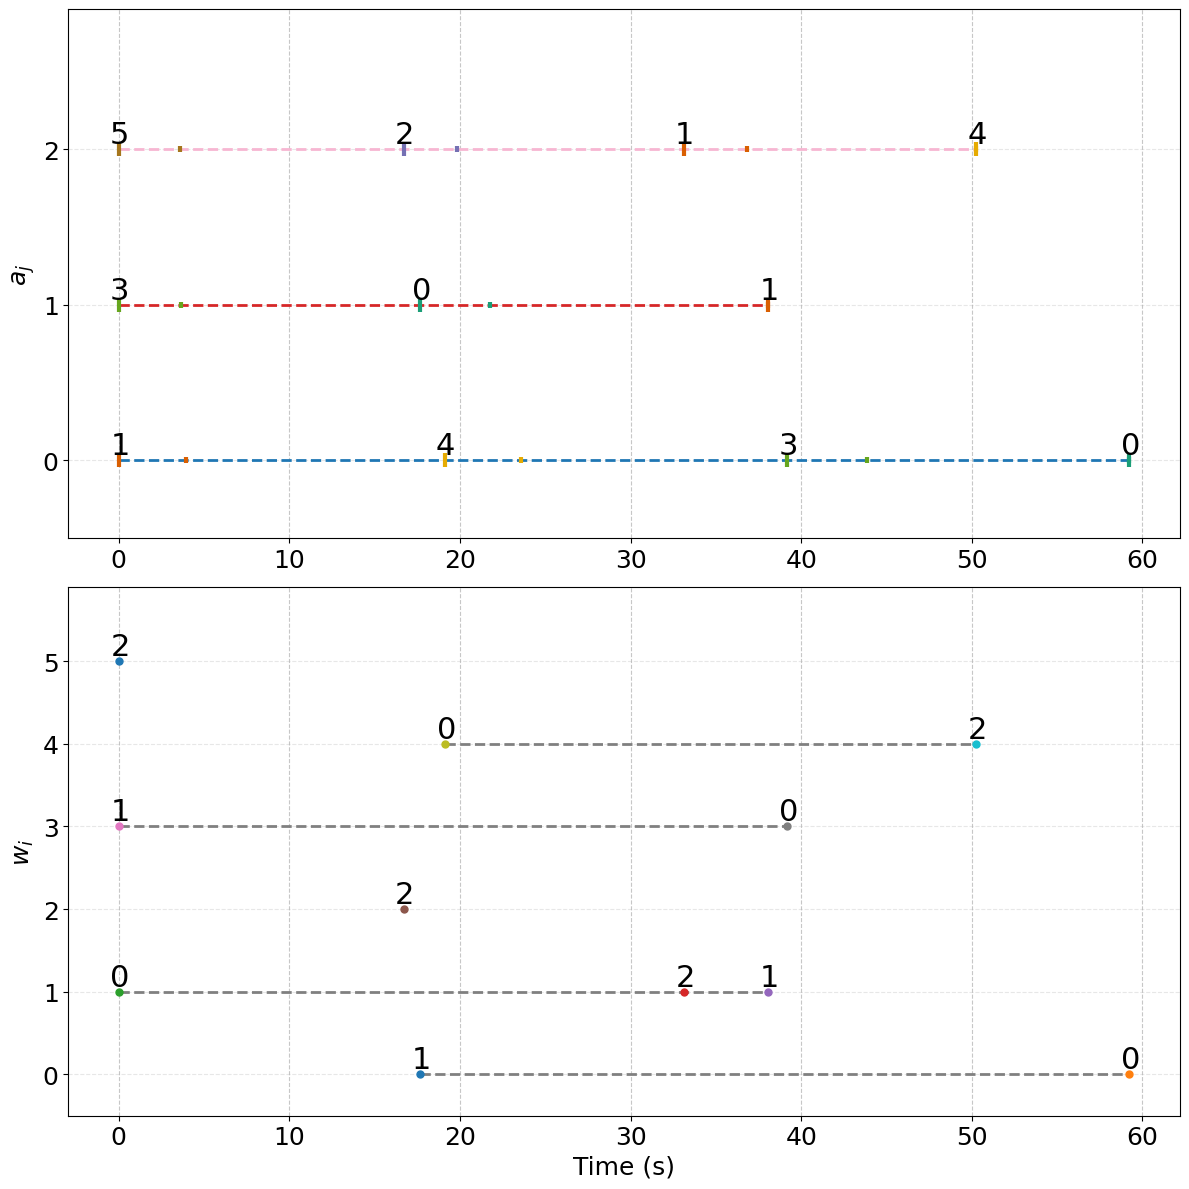

In [19]:

createEnv.plot_waypoint_agent_schedules(
    agent_routes, agent_schedules, mars.sched_mat, 
    filter_wp_final, mars.process_T, agent_colors,
    figuresize=(12,12))